## 1-Dimensional Case

- Key theories used

- Voce hardening

$$
\sigma_y (\epsilon_p) = \sigma_{y0} + Q(1 - e^{(-b \epsilon_p )})
$$

- Perzyna viscoplasticity (viscosity coefficient $\eta_{vp}$ = 20):

$$
\dot{\varepsilon}_p = \frac{\langle \sigma - \sigma_y \rangle}{\eta_{vp}}
\\
\text{where } \langle \cdot \rangle = \max(\cdot, 0)
$$



- Given ε(t) 

- Time loop (as time pass by, the $\epsilon_p$ and $\dot{\epsilon_p}$ and etc.):


$$
\sigma^{tr} = E(\varepsilon - \varepsilon_p)
\\
\sigma_y(\varepsilon_p) = \sigma_{y0} + Q(1 - e^{-b\varepsilon_p})
\\
f = \sigma^{tr} - \sigma_y
\\
\dot{\varepsilon}_p = \frac{\langle f \rangle}{\eta_{vp}}
\\
\varepsilon_p \leftarrow \varepsilon_p + \Delta t \, \dot{\varepsilon}_p
$$

- Here :
- $\epsilon(t)$ is total strain
- $\epsilon_p(t)$ is plastic strain
- $\epsilon_e = \epsilon - \epsilon_p$ is elastic strain
- If $f \le 0$, elastic region
- Elif $f \gt 0$, Perzyna used since plasticity occur
- By using change rate of $\epsilon_p$ and time scale $\Delta T$, $\epsilon_p$ is determined 

- Output sequences:
σ(t), ε_p(t), σ_y(t), f(t) — These are the "ground truth" data that you will use later for training/validating SINDy.

## 3-Dimensional Case
### Von-Mises equivalent stress

# 3D → Equivalent 1D (von Mises Reduction)

## Equivalent Strain

The **von Mises equivalent strain** is defined as:

$$
\varepsilon_{\mathrm{eq}} = \sqrt{\frac{2}{3}} \, \lVert \mathrm{dev}(\boldsymbol{\varepsilon}) \rVert_F
$$


## Equivalent Elastic Relationship

For **small deformations** and **isotropic elasticity**:

$$
\sigma_{\mathrm{eq}} = 3G \, (\varepsilon_{\mathrm{eq}} - \bar{\varepsilon}_p) \quad \text{(NOT } E \text{!)}
$$

### Critical Implementation Detail

In the code, the **"1D modulus"** is set as:

$$
E \equiv 3G
$$

where the shear modulus is:

$$
G = \frac{E_{3D}}{2(1 + \nu)}
$$



---

Plastic fraction (train): 0.109

=== Coefficients (scaled) ===
+9.543827e+00  *  over_eq     
-1.123570e+01  *  epbar       
-0.000000e+00  *  eps_eq_dot  
+0.000000e+00  *  over_eq^2   
+9.678450e-01  *  epbar^2     
+0.000000e+00  *  eps_eq_dot^2

Intercept (unscaled): +1.977602e-03
Top terms (|coef|, unscaled):
+4.535089e+02  *  epbar^2
-2.539954e+01  *  epbar
+5.319968e-02  *  over_eq

Validation RMSE  σ_eq: 1.8598e-03   epbar: 8.0589e-07


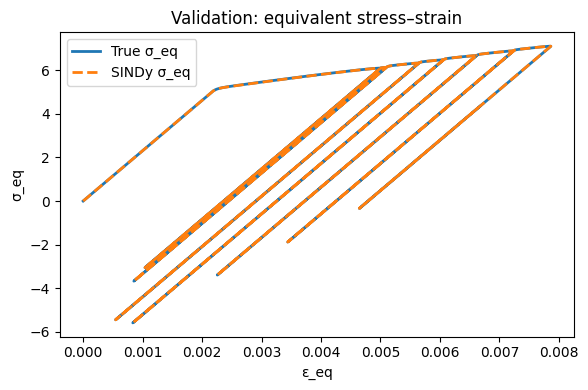

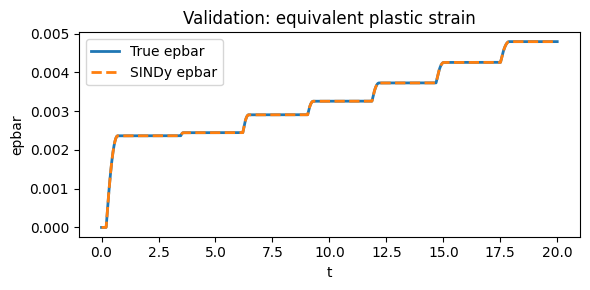

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
import warnings
from pysindy.utils.axes import AxesWarning
warnings.filterwarnings("ignore", category=AxesWarning)

# -----------------------------
# Helpers: dev/eq measures for 3D -> scalar reduction
# -----------------------------
I3 = np.eye(3)

def dev(A):
    """Deviatoric part of a 3x3 tensor."""
    return A - np.trace(A)/3.0 * I3

def eps_eq_from_tensor_series(eps_series):
    """
    Convert a time series of total small-strain tensors (N,3,3)
    to the von Mises equivalent total strain scalar series (N,).
    Use tensorial shear (NOT engineering shear).
    eps_eq = sqrt(2/3) * ||dev(eps)||
    """
    eq = np.zeros(len(eps_series))
    for k, E in enumerate(eps_series):
        ed = dev(E)
        eq[k] = np.sqrt(2.0/3.0) * np.linalg.norm(ed)
    return eq

# -----------------------------
# True material (Voce + Perzyna) in "equivalent" 1D form
# IMPORTANT: E will be set to 3G, not the original Young's modulus.
# -----------------------------
E_3D  = 2000.0       # Young's modulus you would use in 3D
nu    = 0.30         # Poisson's ratio
G     = E_3D / (2*(1+nu))
E     = 3.0 * G      # <-- EFFECTIVE modulus for von Mises equivalent relation

sigy0 = 5.0
Q, b  = 12.0, 40.0             # Voce: sig_y = sigy0 + Q(1 - exp(-b*epbar))
eta_vp = 20.0                  # Perzyna viscosity

def simulate(eps, dt):
    """
    IDENTICAL interface to the original 1D simulate, but now:
    - 'eps' means von Mises equivalent total strain (scalar)
    - 'ep'  means equivalent plastic strain epbar (scalar)
    - 'sig' means von Mises equivalent stress sigma_eq (scalar)
    - Elastic relation is enforced by E = 3G (already set globally)
    """
    ep = np.zeros_like(eps); sig = np.zeros_like(eps)
    sig_y = np.zeros_like(eps); f = np.zeros_like(eps)
    for k in range(1, len(eps)):
        # Elastic predictor in equivalent space: sigma_eq = 3G * (eps_eq - epbar)
        sig[k-1]   = E*(eps[k-1] - ep[k-1])
        # Voce hardening on epbar
        sig_y[k-1] = sigy0 + Q*(1.0 - np.exp(-b*ep[k-1]))
        # Overstress in equivalent form
        f[k-1]     = sig[k-1] - sig_y[k-1]
        # Perzyna (m=1): gamma_dot = <f>/eta
        ep_dot     = max(0.0, f[k-1]) / eta_vp
        # Explicit Euler
        ep[k]      = ep[k-1] + dt * ep_dot
    # last step
    sig[-1]   = E*(eps[-1] - ep[-1])
    sig_y[-1] = sigy0 + Q*(1.0 - np.exp(-b*ep[-1]))
    f[-1]     = sig[-1] - sig_y[-1]
    return sig, ep, sig_y, f

# -----------------------------
# Build a 3D strain path, then REDUCE to equivalent scalar series
# You can replace 'make_path_3d' with your own multi-axial history.
# -----------------------------
dt = 1e-3
t  = np.arange(0, 20, dt)

def make_path_3d(t):
    """
    Example multiaxial path:
    exx(t) = Ax*sin(...) * exp(-a t) + r t   (axial)
    gxy(t) = Ash*sin(...) * exp(-a t)        (engineering shear)
    Store tensorial shear eps_xy = gxy/2
    """
    Ax, fx, ax, r  = 0.006, 0.50, 0.10, 0.0005
    Ash,fsh,ash    = 0.004, 0.35, 0.08
    exx = Ax*np.sin(2*np.pi*fx*t)*np.exp(-ax*t) + r*t
    gxy = Ash*np.sin(2*np.pi*fsh*t)*np.exp(-ash*t)
    eps = np.zeros((len(t),3,3))
    eps[:,0,0] = exx
    eps[:,0,1] = eps[:,1,0] = 0.5 * gxy  # tensorial shear
    return eps

def make_path_3d_val(t):
    Ax, fx, ax, r  = 0.007, 0.35, 0.05, 0.0005
    Ash,fsh,ash    = 0.003, 0.42, 0.06
    exx = Ax*np.sin(2*np.pi*fx*t)*np.exp(-ax*t) + r*t
    gxy = Ash*np.sin(2*np.pi*fsh*t)*np.exp(-ash*t)
    eps = np.zeros((len(t),3,3))
    eps[:,0,0] = exx
    eps[:,0,1] = eps[:,1,0] = 0.5 * gxy
    return eps

eps3D_tr = make_path_3d(t)
eps3D_va = make_path_3d_val(t)

# Collapse 3D -> scalar equivalent total strain histories
eps_tr = eps_eq_from_tensor_series(eps3D_tr)  # <-- use this as "eps" in 1D code
eps_va = eps_eq_from_tensor_series(eps3D_va)

# -----------------------------
# Generate 'true' data in equivalent space (same pipeline as your 1D code)
# -----------------------------
sig_tr, ep_tr, sigy_tr, f_tr = simulate(eps_tr, dt)  # sig==sigma_eq, ep==epbar
sig_va, ep_va, sigy_va, f_va = simulate(eps_va, dt)

# Time derivatives
epsdot_tr = np.gradient(eps_tr, dt); epdot_tr = np.gradient(ep_tr, dt)   # epsdot_eq, epbar_dot
epsdot_va = np.gradient(eps_va, dt); epdot_va = np.gradient(ep_va, dt)

# -----------------------------
# Overstress features: X = [over_eq, epbar, eps_eq_dot]
# (Names kept as in your code for minimal change, but interpret accordingly.)
# -----------------------------
sigy0_hat = sig_tr[np.argmax(ep_tr > 0)]        # first plastic point estimate
over_tr   = sig_tr - sigy0_hat                  # equivalent overstress with fixed sigy0_hat
over_va   = sig_va - sigy0_hat

tol = 1e-10
mask_pl = epdot_tr > tol
print(f"Plastic fraction (train): {mask_pl.mean():.3f}")

X_raw = np.column_stack([over_tr, ep_tr, epsdot_tr])[mask_pl]
y_raw = epdot_tr[mask_pl]  # target: epbar_dot

# -----------------------------
# Θ via PolynomialLibrary on [over_eq, epbar, eps_eq_dot]
# -----------------------------
names = ["over_eq","epbar","eps_eq_dot"]
poly = ps.PolynomialLibrary(degree=2, include_bias=False, include_interaction=False)
Phi_raw  = poly.fit_transform(X_raw)
phi_names= poly.get_feature_names(input_features=names)

# -----------------------------
# Z-score Θ and y (fit on TRAIN-plastic)
# -----------------------------
Xmu  = Phi_raw.mean(0);  Xstd = Phi_raw.std(0) + 1e-12
ymu  = y_raw.mean();     ystd = y_raw.std()    + 1e-12

Phi = (Phi_raw - Xmu)/Xstd
y   = (y_raw  - ymu)/ystd

# -----------------------------
# Fit (SR3), same as your code
# -----------------------------
lib = ps.IdentityLibrary()
opt = ps.SR3(reg_weight_lam=0.1, relax_coeff_nu=1, max_iter=10000, tol=1e-12)
model = ps.SINDy(feature_library=lib, optimizer=opt)
model.feature_names = phi_names
model.state_names   = ["epbar"]
model.fit(Phi, t=dt, x_dot=y)

# -----------------------------
# Coefficients (scaled & unscaled) + print
# -----------------------------
coefs_s = np.ravel(model.coefficients()[0])
w_unscaled = (ystd / Xstd) * coefs_s
b_unscaled = ymu - np.dot(w_unscaled, Xmu)

w_len = max(12, max(len(n) for n in phi_names))
print("\n=== Coefficients (scaled) ===")
for c, n in zip(coefs_s, phi_names):
    print(f"{c:+12.6e}  *  {n:<{w_len}}")
print("\nIntercept (unscaled):", f"{b_unscaled:+.6e}")
print("Top terms (|coef|, unscaled):")
order = np.argsort(-np.abs(w_unscaled))
for j in order[:8]:
    if abs(w_unscaled[j]) > 0:
        print(f"{w_unscaled[j]:+.6e}  *  {phi_names[j]}")

# -----------------------------
# FAST RHS in equivalent space (no model.predict)
# -----------------------------
def epbardot_fast(over_eq, epbar, eps_eq_dot):
    Phi_row = poly.transform(np.array([[over_eq, epbar, eps_eq_dot]]) )[0]
    g = float(b_unscaled + np.dot(w_unscaled, Phi_row))
    return max(0.0, g)  # physical cutoff

# -----------------------------
# Rollout on VALIDATION in equivalent space
# -----------------------------
ep_hat = np.zeros_like(ep_va)  # epbar_hat
for k in range(1, len(t)):
    sig_k  = E*(eps_va[k-1] - ep_hat[k-1])   # sigma_eq
    over_k = sig_k - sigy0_hat               # over_eq (fixed sigy0_hat)
    gk     = epbardot_fast(over_k, ep_hat[k-1], epsdot_va[k-1])
    ep_hat[k] = ep_hat[k-1] + dt*gk
sig_hat = E*(eps_va - ep_hat)                # sigma_eq_hat

rmse_sig = np.sqrt(np.mean((sig_hat - sig_va)**2))
rmse_ep  = np.sqrt(np.mean((ep_hat  - ep_va )**2))
print(f"\nValidation RMSE  σ_eq: {rmse_sig:.4e}   epbar: {rmse_ep:.4e}")

# -----------------------------
# Plots in equivalent space
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(eps_va, sig_va,  lw=2, label="True σ_eq")
plt.plot(eps_va, sig_hat, "--", lw=2, label="SINDy σ_eq")
plt.xlabel("ε_eq"); plt.ylabel("σ_eq"); plt.title("Validation: equivalent stress–strain")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(t, ep_va,  lw=2, label="True epbar")
plt.plot(t, ep_hat, "--", lw=2, label="SINDy epbar")
plt.xlabel("t"); plt.ylabel("epbar"); plt.title("Validation: equivalent plastic strain")
plt.legend(); plt.tight_layout(); plt.show()


# Learned Plasticity Evolution Equation

The predicted equivalent plastic strain rate is:

$$
\dot{\bar{\varepsilon}}_p^{\text{pred}} = \max\left(0, \, b_0 + w_{\text{over}}(\sigma_{\text{eq}} - \sigma_{y0}) + w_1 \bar{\varepsilon}_p + w_2 \bar{\varepsilon}_p^2 \right)
$$

---

## Fitted Coefficients

Substituting your numerical values (rounded):

- $b_0 \approx 1.98 \times 10^{-3}$
- $w_{\text{over}} \approx 0.05320$ $\quad (\approx 1/\eta)$
- $w_1 \approx -25.40$ $\quad (\approx -Qb/\eta)$
- $w_2 \approx +453.51$ $\quad (\approx +Qb^2/(2\eta))$

---

## Physical Interpretation

This is a **quadratic polynomial approximation** of the **Perzyna + Voce exponential hardening** model.

The $\max(0, \cdot)$ operation is a **physical constraint** you added to enforce **irreversible plasticity** (plastic strain rate cannot be negative).

---

## Model Form

| Term | Coefficient | Physical Meaning |
|------|-------------|------------------|
| Constant | $b_0$ | Baseline plastic flow rate |
| $(\sigma_{\text{eq}} - \sigma_{y0})$ | $w_{\text{over}}$ | Overstress sensitivity $\sim 1/\eta$ (viscosity) |
| $\bar{\varepsilon}_p$ | $w_1$ | Linear hardening (negative = softening effect) |
| $\bar{\varepsilon}_p^2$ | $w_2$ | Quadratic hardening (positive = saturation) |

The learned coefficients approximate the Voce hardening law:

$$
\sigma_y(\bar{\varepsilon}_p) = \sigma_{y0} + Q(1 - e^{-b\bar{\varepsilon}_p})
$$

through a second-order Taylor expansion.